In [3]:
%matplotlib inline

import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns =50

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from statistics import *
import concurrent.futures
import time
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib.colors import ListedColormap
import seaborn as sns
color = sns.color_palette()

import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import defaultdict

import unicodedata
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import re
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidkolb/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/Users/davidkolb/Documents/Kaggle/Kaggle/NLPNovice


In [5]:
train = pd.read_csv('../../Data/NLPNovice/train.csv')
test = pd.read_csv('../../Data/NLPNovice/test.csv')

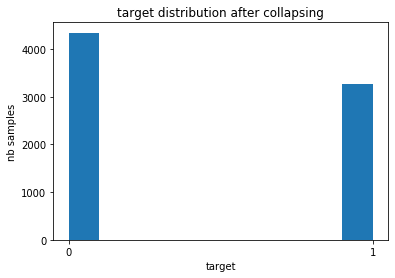

In [6]:
target = train['target']
plt.hist(target)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution after collapsing')
plt.xticks(np.arange(len(np.unique(target))));

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [83]:
train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


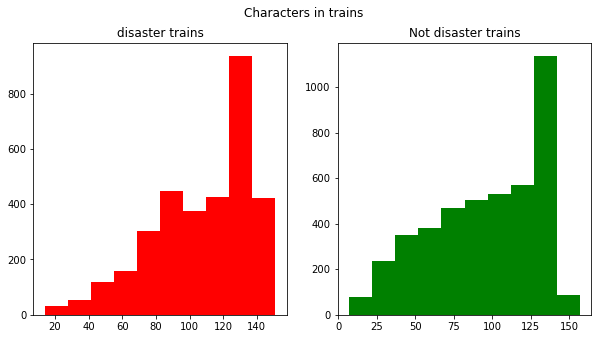

In [85]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster trains')
fig.suptitle('Characters in trains')
plt.show()

In [86]:
#Check missing train data ratios 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

,Missing Ratio
location,33.272035
keyword,0.801261


In [87]:
#Check missing test data ratios 
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head()

,Missing Ratio
location,33.864542
keyword,0.796813


In [88]:
#check for skewwness in data 
skewness = pd.DataFrame(train.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness

,Skew
target,0.284243
id,0.007607


In [89]:
#Add meta data features
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [90]:
# fig =plt.figure(figsize=(15,15),dpi=100)
# sns.set_context('notebook',font_scale=1.3)
# sns.set_style('whitegrid')
# g=sns.pairplot(train[['word_count',
#                 'unique_word_count',
#                 'stop_word_count',
#                 'char_count',
#                 'target']],hue='target')

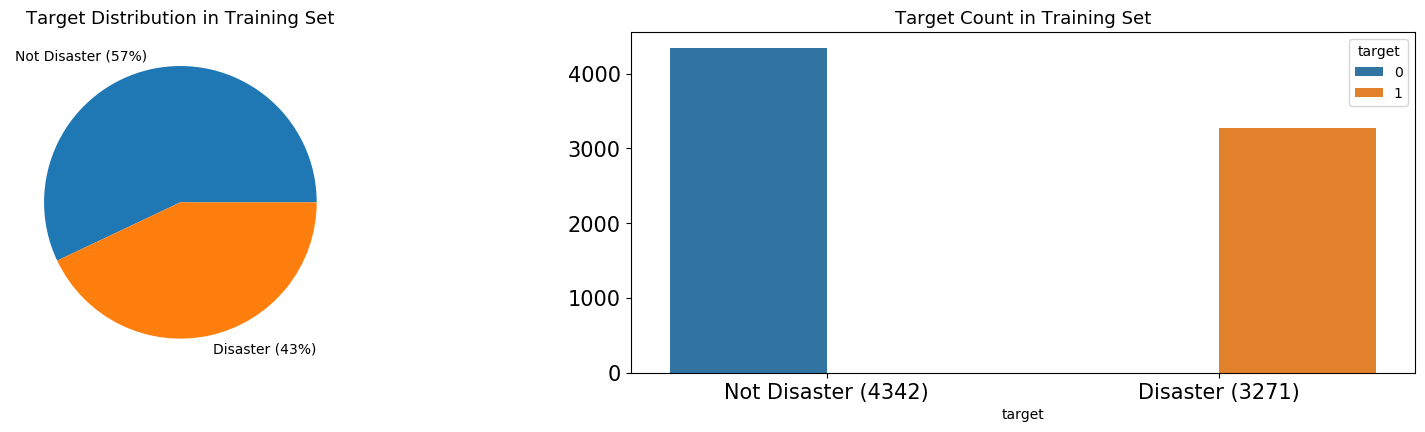

In [91]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [92]:
# N-gram analysis
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

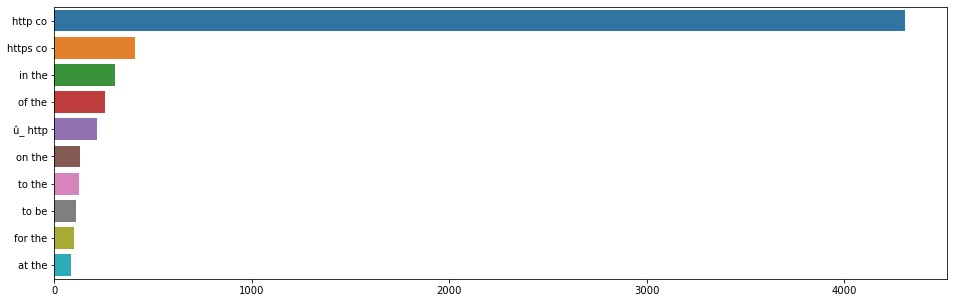

In [93]:
plt.figure(figsize=(16,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

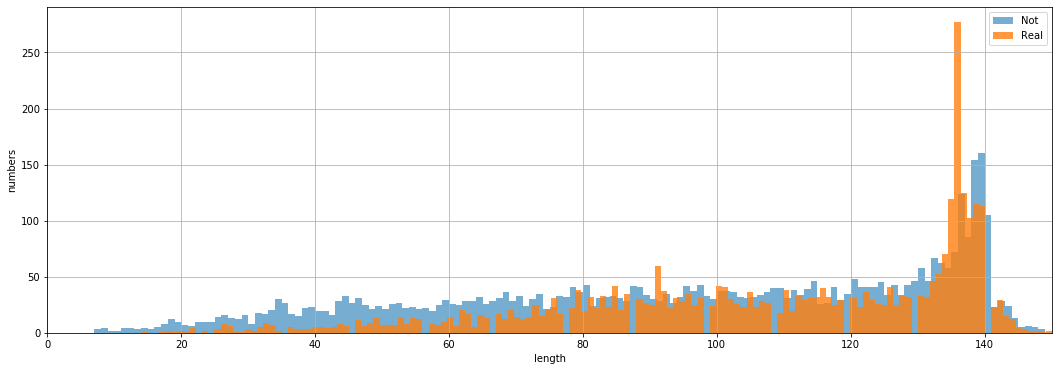

In [94]:
# Characters per tweet
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['char_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['char_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

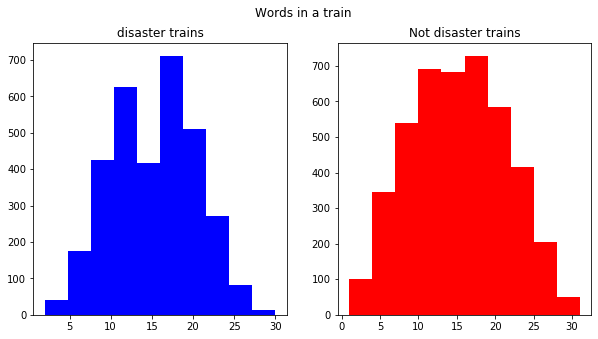

In [95]:
# Number of words in train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster trains')
fig.suptitle('Words in a train')
plt.show()

Text(0.5, 0.98, 'Average word length in each train')

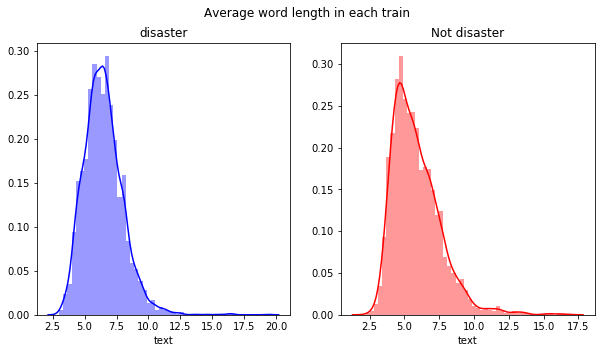

In [96]:
#Average word length in a train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each train')

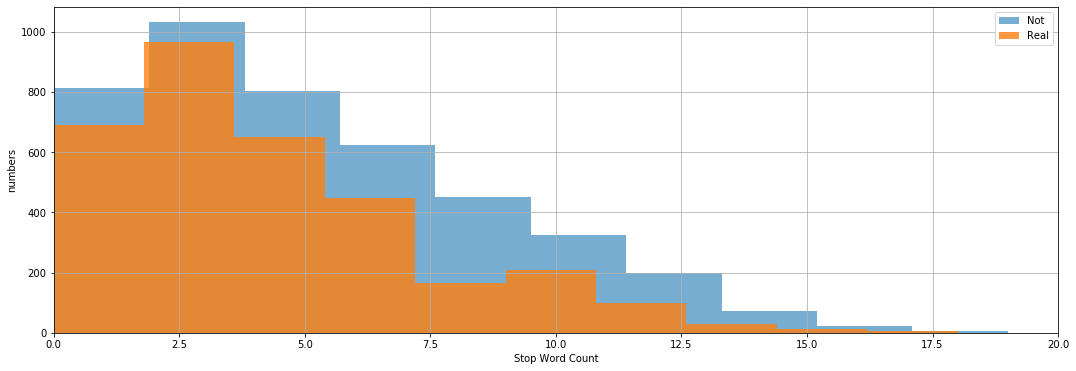

In [97]:
# stop_word_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['stop_word_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['stop_word_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Stop Word Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,20)
plt.grid()
plt.show()

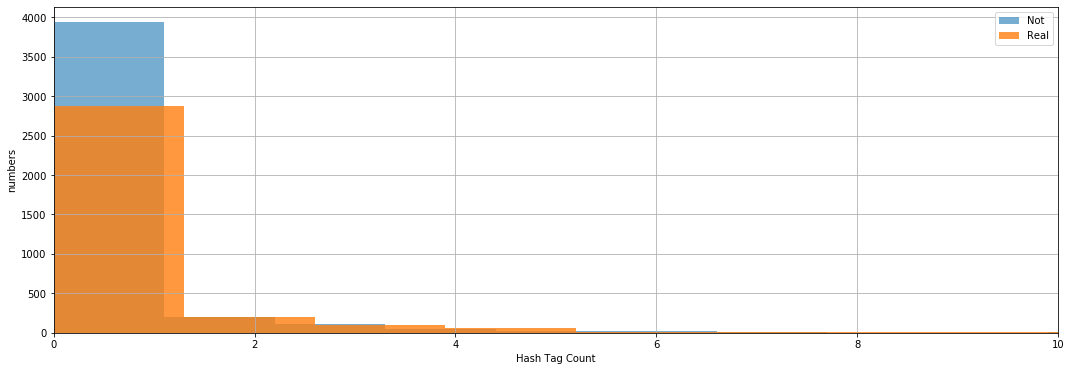

In [98]:
# hashtag_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['hashtag_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['hashtag_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Hash Tag Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,10)
plt.grid()
plt.show()

In [99]:
#Create a list of words
def create_corpus(target):
    corpus=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#Create list of stop words
def stop_words(data):
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    return dic

#Create list of puntcuation
def punt_words(data):
    dic=defaultdict(int)
    special = string.punctuation
    for i in (corpus):
        if i in special:
            dic[i]+=1
    return dic

<BarContainer object of 10 artists>

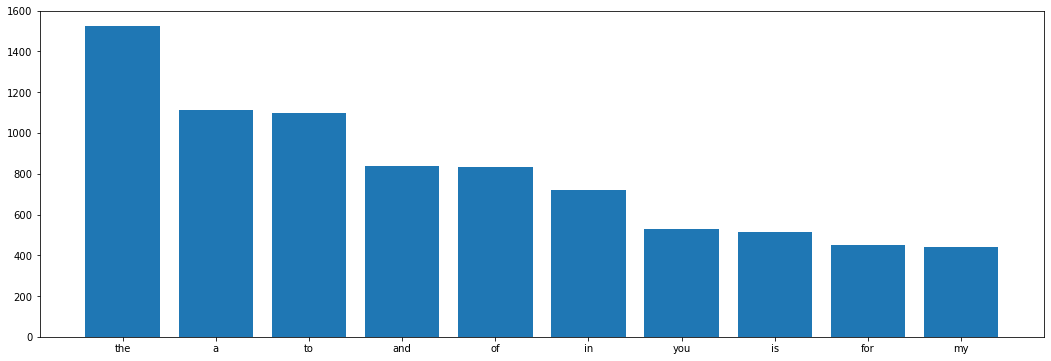

In [100]:
# Common stop words in class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

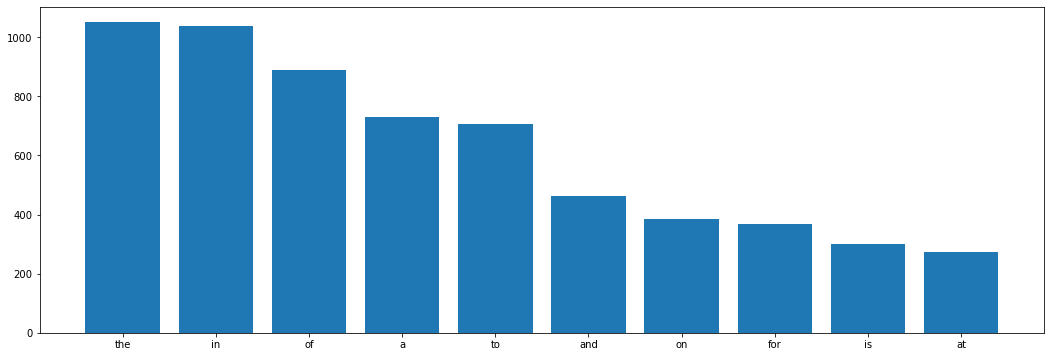

In [101]:
# Common stop words in class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

# Cleaing the Data

In [102]:
def remove_whitespace(data):
    return data.strip()

In [103]:
def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',data)

In [104]:
def remove_html(data):
    html=re.compile(r'<.*?>')
    return html.sub(r'',data)

In [105]:
def remove_emoji(data):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)

In [106]:
def remove_accented_chars(data):
    return unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [107]:
def remove_punctuation(data):
    table=str.maketrans('','',string.punctuation)
    return data.translate(table)

In [108]:
def single_char(data):
    new_data=''
    for w in data:
        print(w)
        if len(w) > 1:
            print(w)
            new_data = new_data +  " " + w
    
    return new_data

In [109]:
def remove_special_characters(data, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    data = re.sub(pattern, '', data)
    return data

In [110]:
def convert_lower_case(data):
    return data.lower()

In [111]:
def tokenise(data):
    data = word_tokenize(data)
    return data

In [112]:
def remove_stop_words(data):
    filtered_sentence = [w for w in data if not w in stop_words] 
    return filtered_sentence

In [113]:
def stemming(data):
    data.apply(lambda x: [stemmer.stem(e) for e in x])
    return data

In [114]:
def lemmatise(data):
    lemmatizer = WordNetLemmatizer()
    data.apply(lambda x: [lemmatizer.lemmatize(e) for e in x])
    return data 

In [115]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english")

In [116]:
def nlp_clean(data):
    data = remove_URL(data)
    data = remove_html(data)
    data = remove_emoji(data)
    data = remove_whitespace(data)    
    data = remove_accented_chars(data) 
    data = remove_special_characters(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data
    
def nlp_tokenise(data):
    data = tokenise(data)
    data = remove_stop_words(data)
    return data
     
def nlp_normalise(data):
    data = stemming(data)
    data = lemmatise(data)
    return data

In [117]:
# Run preprossing steps to clean data
train['text']=train['text'].apply(lambda x : nlp_clean(x))
test['text']=test['text'].apply(lambda x : nlp_clean(x))

In [118]:
# Run steps to remove stop words
train['text']=train['text'].apply(lambda x : nlp_tokenise(x))
test['text']=test['text'].apply(lambda x : nlp_tokenise(x))

In [119]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [120]:
# Find and wordcloud common words
all_train_words = []
for text in train['text']:
    for word in text:
        all_train_words.append(word)

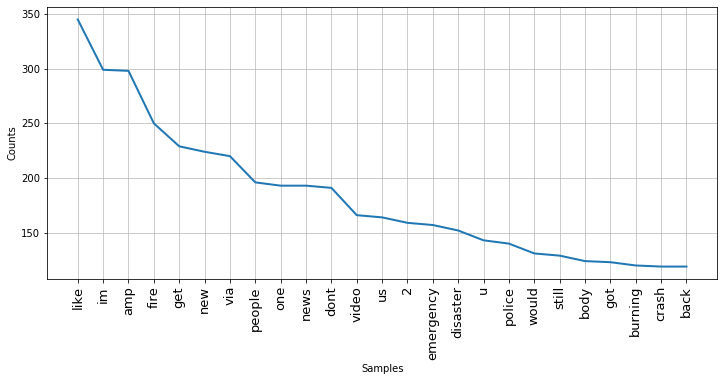

In [121]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_train_words)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_train_words).values(), reverse=True)

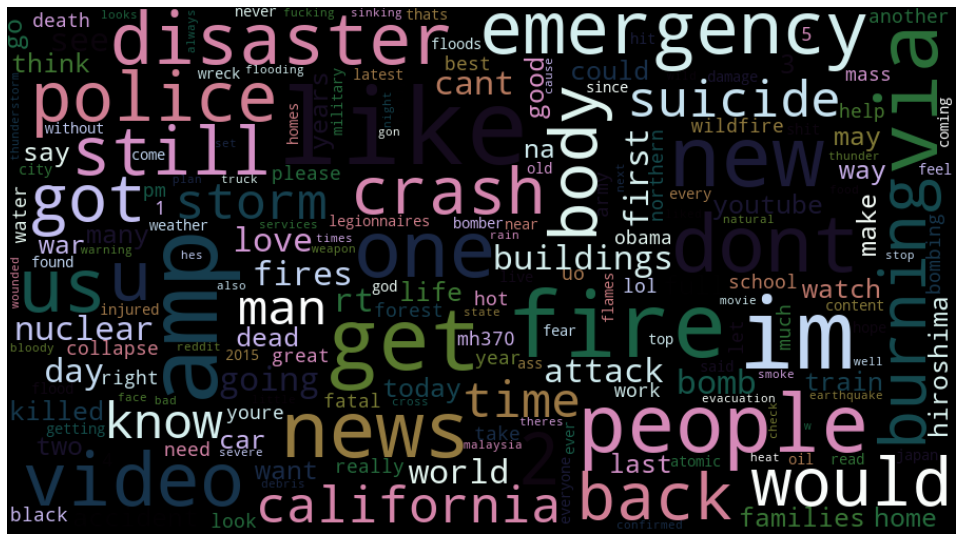

In [122]:
# create a word frequency dictionary
wordfreq = Counter(all_train_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [123]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [124]:
train['text2'] = train['text']
test['text2'] = test['text']

In [125]:
#Join Data
def combine_text(list_of_text):
    combined_text = ''
    for word in list_of_text:
        combined_text = combined_text + ' ' + word
    return combined_text

In [126]:
train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [204]:
train.to_csv('DSKtrain.csv', index=False)
test.to_csv('DSKtest.csv', index=False)

In [128]:
# List of models
model = pd.DataFrame(columns=['Model','Count','TFIDF'])

# count_vectorizer

In [154]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

In [155]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(train_vectors)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [156]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
# The lower the IDF value of a word, the less unique it is to any particular document.
df_idf.sort_values(by=['idf_weights'])

,idf_weights
like,4.141686
im,4.324616
amp,4.339322
fire,4.495326
get,4.521644
...,...
harvardu,9.244597
harvesting,9.244597
harveymaine,9.244597
harperanetflixshow,9.244597


In [157]:
# Compute the TFIDF score for your documents
count_vector=count_vectorizer.transform(train['text'])
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

feature_names = count_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

#The more common the word across documents, the lower its score and 
#the more unique a word the higher the score

,tfidf
deeds,0.470046
forgive,0.470046
allah,0.406021
reason,0.366567
earthquake,0.326038
...,...
faith,0.000000
fake,0.000000
faked,0.000000
falcon,0.000000


# tfidf_vectorizer

In [158]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
test_tfidf = tfidf_vectorizer.transform(test['text'])
print(train_tfidf.shape)

(7613, 17915)


In [159]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=train_tfidf[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
deeds,0.470046
forgive,0.470046
allah,0.406021
reason,0.366567
earthquake,0.326038
...,...
faith,0.000000
fake,0.000000
faked,0.000000
falcon,0.000000


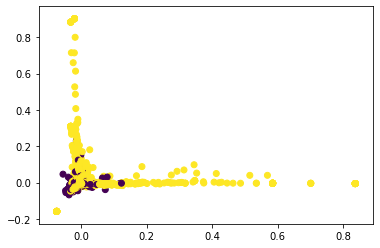

In [160]:
pca = PCA(n_components=2)
pca.fit(train_tfidf.todense())
data2D = pca.transform(train_tfidf.todense())
plt.scatter(data2D[:,0], data2D[:,1], c=train.target)
plt.show()  

# Logistic Regression Classifier

In [161]:
#Fitting on Counter Vectoriser
clf = LogisticRegression(C=1.0)
scorecount = model_selection.cross_val_score(clf, train_vectors, train['target'], cv=5, scoring='accuracy')

In [162]:
clf.fit(train_vectors, train['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [163]:
clf.score(train_vectors, train['target'])

0.9592801786417969

In [164]:
# Fitting on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scoretfidf = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv=5, scoring='accuracy')

In [165]:
clf_tfidf.fit(train_vectors, train['target'])
clf_tfidf.score(train_vectors, train['target'])

0.9592801786417969

In [394]:
model = model.append({'Model':'Logr',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

# Naives Bayes Classifier

In [167]:
#Fitting on Counter Vectoriser
clf_NB = MultinomialNB()
scorecount = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring='accuracy')

In [168]:
clf_NB.fit(train_vectors, train['target'])
clf_NB.score(train_vectors, train['target'])

0.9160646262971234

In [169]:
# Fitting on TFIDF
clf_NB_TFIDF = MultinomialNB()
scoretfidf = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring='accuracy')

In [170]:
clf_NB_TFIDF.fit(train_vectors, train['target'])
clf_NB_TFIDF.score(train_vectors, train['target'])

0.9160646262971234

In [171]:
model = model.append({'Model':'Bayes',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

AttributeError: 'Sequential' object has no attribute 'append'

# XGBoost

In [400]:
# #Fitting on Counter Vectoriser
# clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# scorecount = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
# # Fitting on TFIDF
# clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# scoretfidf = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring='accuracy')

In [ ]:
# model = model.append({'Model':'XGB',
#                      'Count':scorecount.mean(),
#                      'TFIDF':scoretfidf.mean()}, ignore_index=True)

In [401]:
model

,Model,Count,TFIDF
0,Logr,0.685536,0.703534
1,Bayes,0.703932,0.722718


# Glove

In [210]:
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

# For Glove examples 
from scipy import spatial
from sklearn.manifold import TSNE

In [211]:
train.shape

(7613, 15)

In [212]:
corpus=[]
for word in tqdm(train['text']):
    words=[word.lower() for word in word_tokenize(word)]
    corpus.append(words)

100%|██████████| 7613/7613 [00:00<00:00, 9647.89it/s]


In [221]:
embedding_dict={}
with open('../../Data/NLPNovice/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [222]:
len(embedding_dict)

400000

In [223]:
# Examples Using Pre-trained GloVe Vectors in Python
def find_closest_embeddings(embedding):
    return sorted(embedding_dict.keys(), key=lambda word: spatial.distance.euclidean(embedding_dict[word], embedding))

In [224]:
# Examples Using Pre-trained GloVe Vectors in Python
print(find_closest_embeddings(embedding_dict['house'])[1:10])

['office', 'room', 'capitol', 'houses', 'mansion', 'once', 'home', 'senate', 'building']


In [225]:
# Examples Using Pre-trained GloVe Vectors in Python
print(find_closest_embeddings(
    embedding_dict['brick'] - embedding_dict['roof'] + embedding_dict['door'])[:5])

['door', 'brick', 'storefront', 'shop', 'courthouse']


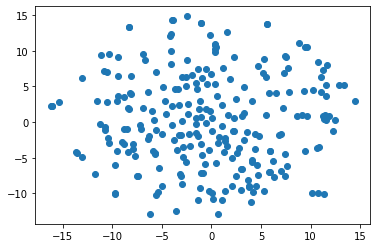

In [218]:
# Examples Using Pre-trained GloVe Vectors in Python
tsne = TSNE(n_components=2, random_state=0)
words =  list(embedding_dict.keys())
vectors = [embedding_dict[word] for word in words]
ytsne = tsne.fit_transform(vectors[:250])
plt.scatter(ytsne[:, 0], ytsne[:, 1])

In [203]:
for label, x, y in zip(words, ytsne[:, 0], ytsne[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [132]:
# Back to the globel model
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

text_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [133]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 17943


In [134]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec    

100%|██████████| 17943/17943 [00:00<00:00, 429618.36it/s]


In [135]:
text_pad[0][0:]

array([4366,  715,  153,   55, 1452, 4367,   13,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [136]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [137]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1794400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,874,901
Trainable params: 80,501
Non-trainable params: 1,794,400
_________________________________________________________________


In [138]:
train_glove=text_pad[:train.shape[0]]
test_glove=text_pad[train.shape[0]:]

In [139]:
X_train,X_test,y_train,y_test=train_test_split(train_glove,train['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [140]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 132s - loss: 0.5653 - accuracy: 0.7399 - val_loss: 0.5265 - val_accuracy: 0.7702
Epoch 2/10
 - 133s - loss: 0.5415 - accuracy: 0.7598 - val_loss: 0.5053 - val_accuracy: 0.7971
Epoch 3/10
 - 104s - loss: 0.5624 - accuracy: 0.7248 - val_loss: 0.5756 - val_accuracy: 0.7144
Epoch 4/10
 - 106s - loss: 0.5891 - accuracy: 0.6989 - val_loss: 0.5564 - val_accuracy: 0.7571
Epoch 5/10
 - 101s - loss: 0.5741 - accuracy: 0.7379 - val_loss: 0.5564 - val_accuracy: 0.7557
Epoch 6/10
 - 100s - loss: 0.5611 - accuracy: 0.7491 - val_loss: 0.5407 - val_accuracy: 0.7708
Epoch 7/10
 - 100s - loss: 0.5383 - accuracy: 0.7621 - val_loss: 0.4884 - val_accuracy: 0.7912
Epoch 8/10
 - 102s - loss: 0.5145 - accuracy: 0.7706 - val_loss: 0.5076 - val_accuracy: 0.7905
Epoch 9/10
 - 101s - loss: 0.5088 - accuracy: 0.7698 - val_loss: 0.4860 - val_accuracy: 0.7899
Epoch 10/10
 - 106s - loss: 0.5093 - accuracy: 0.7744 - val_loss: 0.5055 - val_accuracy: 0.7853


In [142]:
train_pred_GloVe = model.predict(train_glove)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

AttributeError: 'History' object has no attribute 'most_similar'

# BERT

In [85]:
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import tensorflow_hub as hub
from tensorflow import keras
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange

In [69]:
train_char = train['text'].apply(lambda x: len(str(x))).max()
test_char = test['text'].apply(lambda x: len(str(x))).max()
train_char

139

In [70]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

In [96]:
# https://towardsdatascience.com/bert-to-the-rescue-17671379687f
    
train_cls = train['text'].apply(lambda x: str('[CLS]' + x + '[SEP]'))
test_cls =  test['text'].apply(lambda x: str('[CLS]' + x + '[SEP]'))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = train_cls.apply(lambda x: tokenizer.tokenize(x))
test_tokens = test_cls.apply(lambda x: tokenizer.tokenize(x))

#create IDs
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

#Create Pad Sequences and pad with zeroes
maxlen=140
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=140, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=140, truncating="post", padding="post", dtype="int")


In [97]:
# Create attention masks for training
attention_masks_train = []

# For each sentence...
for sent in train_tokens_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_train.append(att_mask)

In [98]:
# Create attention masks for test
attention_masks_test = []

# For each sentence...
for sent in test_tokens_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_test.append(att_mask)

In [105]:
target=train['target']
target = target.map( {'1': True, '0': False} ).astype(bool)

0       True
1       True
2       True
3       True
4       True
        ... 
7608    True
7609    True
7610    True
7611    True
7612    True
Name: target, Length: 7613, dtype: bool

In [109]:
# Use train_test_split to split our data into train and validation sets for
# training
# Use 90% for training and 10% for validation.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_tokens_ids, target, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks_train, target,
                                             random_state=2018, test_size=0.1)

In [110]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

KeyError: 3

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [75]:
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/
model =  BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

[('bert.embeddings.word_embeddings.weight', Parameter containing:
  tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
          [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
          [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
          ...,
          [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
          [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
          [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight', Parameter containing:
  tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
            6.8312e-04,  1.5441e-02],
          [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
            2.9753e-02, -5.3247e-03],
          [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
            1.8741e-02, -7.3140e-03],
          ...,
          [ 1.7418e-02,  3.4903e-03, -9.5621e-03,

In [76]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [80]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [84]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

NameError: name 'train_dataloader' is not defined

In [23]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

NameError: name 'train' is not defined

In [ ]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)
clf.train(df_train)

# Final Submission

In [172]:
pred = clf_tfidf.predict(test_tfidf)

In [174]:
pred.shape

(3263,)

In [175]:
train_pred_GloVe_int.shape

(7613, 1)

In [176]:
output=pd.DataFrame({'id':test.id, 'target':pred})
output.to_csv('../../Data/NLPNovice/DSKsubmission.csv', index=False)

In [213]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


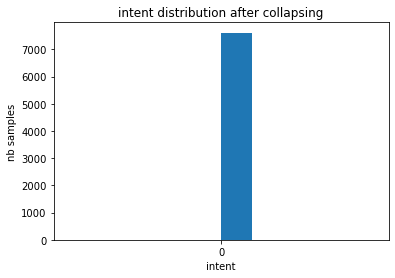

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: target, Length: 7613, dtype: int64